In [1]:
from keras.layers import Convolution2D ,MaxPooling2D,Flatten
from keras.layers.core import Dense, Dropout, Activation
from sklearn.cross_validation import train_test_split
from keras.callbacks import History,Callback
from sklearn.metrics import classification_report
from sklearn.cross_validation import StratifiedKFold ,cross_val_score
from keras.models import model_from_config
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.regularizers import l2
from keras import backend as K
import theano.tensor as T
import theano
import keras
import pickle


Using Theano backend.
Using gpu device 0: GeForce 940M (CNMeM is disabled, CuDNN not available)
C:\Users\Back_jud\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning:

downsample module has been moved to the theano.tensor.signal.pool module.



In [2]:
# binary category to label 
def cat2lab (x):
    '''only for binary category'''
    return np.array([0 if s[0] else 1 for s in x])

### Loading data from pickle and formatting

In [3]:
a = open('d://labels_new.p')
b = open('d://images_new.p')
labels = np.array(pickle.load(a))
imgs = np.array(pickle.load(b))
imgsr = imgs /255
labels = np_utils.to_categorical(labels,nb_classes=2)

In [4]:
orimgs =[]
for img in imgsr:
    orimgs.append(np.reshape(img,(50,50))) 
orimgs = np.array(orimgs)

### Split data

In [5]:
x_tr,x_te,y_tr,y_te = train_test_split(orimgs,labels,test_size= 0.2,random_state= 123)

In [6]:
x_tr1,x_te1,y_tr1,y_te1 = train_test_split(imgsr,labels,test_size= 0.2,random_state= 123)

## Trial1.Simple neuron

### need to add regularizer  L2 , activity L2 for further use


In [7]:
model1 = Sequential()
model1.add(Dense(2500, input_dim=2500,init ='uniform'))
model1.add(Activation('relu'))
model1.add(Dense(2, activation="softmax"))
model1.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01,decay= 1e-6,momentum=0.1,nesterov=True))

In [8]:
%time hist1 = model1.fit(x_tr1, np.array(y_tr1), nb_epoch=300,validation_split=0.2 ,batch_size=50,show_accuracy=True,verbose=0)

Wall time: 24.6 s


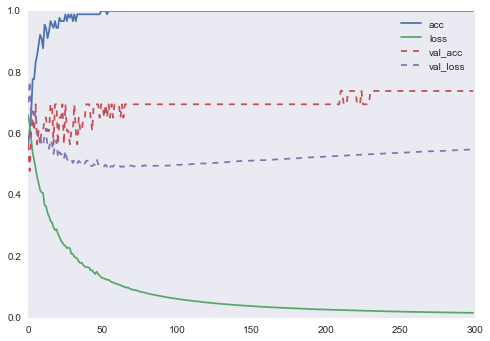

In [9]:
plt.plot(hist1.history['acc'],label='acc')
plt.plot(hist1.history['loss'],label='loss')
plt.plot(hist1.history['val_acc'],'--',label='val_acc')
plt.plot(hist1.history['val_loss'],'--',label='val_loss')
plt.grid('off')
plt.legend()

In [10]:
model1.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 2500)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 2500)                  6252500             
Activation (activation)       (None, 2500)                  0                   
Dense (dense)                 (None, 2)                     5002                
--------------------------------------------------------------------------------
Total params: 6257502
--------------------------------------------------------------------------------


In [11]:
model1.evaluate(x_te1,y_te1,batch_size=50,show_accuracy=True)

29/29 [==============================] - 0s


[0.63991600275039673, 0.72413793103448276]

In [12]:
y_pred1 = model1.predict_classes(x_te1,20)
y_pred1

29/29 [==============================] - 0s     


array([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1], dtype=int64)

In [13]:
y_ten1 = cat2lab(y_te1)
y_ten1

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1])

In [14]:
print(classification_report(y_ten1,y_pred1))

             precision    recall  f1-score   support

          0       0.62      0.73      0.67        11
          1       0.81      0.72      0.76        18

avg / total       0.74      0.72      0.73        29



In [15]:
for i in model1.get_weights():
    print(np.shape(i))

(2500L, 2500L)
(2500L,)
(2500L, 2L)
(2L,)


## Trial2. CNN

In [16]:
#reshape to shape (1,50,50) for CNN
imgs2d= []
for img in imgsr:
    imgs2d.append(np.reshape(img,(1,50,50)))
imgs2d = np.array(imgs2d)

In [17]:
x_tr2,x_te2,y_tr2,y_te2 = train_test_split(imgs2d,labels,test_size= 0.2,random_state= 123)

### what about cross validation to CNN

In [20]:
model2 = Sequential()
model2.add(Convolution2D(20,10, 10, border_mode='same', input_shape=(1, 50, 50)))
model2.add(Activation('relu'))
# model2.add(Convolution2D(50, 5, 5,init='uniform'))
# model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

model2.add(Convolution2D(10, 10, 10,init='uniform' ,border_mode='same'))
model2.add(Activation('relu'))
# model2.add(Convolution2D(100, 5, 5,init='uniform'))
# model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

model2.add(Flatten())
model2.add(Dense(1250,init='uniform'))
model2.add(Activation('relu'))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01,decay=1e-6,
                                                              momentum=0.9,
                                                              nesterov=True))

In [21]:
%time hist2 = model2.fit(x_tr2, y_tr2, nb_epoch=300 , batch_size=50 ,validation_split=0.2, show_accuracy=True ,shuffle=True)

Train on 90 samples, validate on 23 samples
Epoch 1/300
90/90 [==============================] - 0s - loss: 1.6465 - acc: 0.4222 - val_loss: 0.6822 - val_acc: 0.6087
Epoch 2/300
90/90 [==============================] - 0s - loss: 0.7162 - acc: 0.4444 - val_loss: 0.6869 - val_acc: 0.6087
Epoch 3/300
90/90 [==============================] - 0s - loss: 0.7125 - acc: 0.4444 - val_loss: 0.6903 - val_acc: 0.5652
Epoch 4/300
90/90 [==============================] - 0s - loss: 0.6995 - acc: 0.4444 - val_loss: 0.6940 - val_acc: 0.4783
Epoch 5/300
90/90 [==============================] - 0s - loss: 0.6962 - acc: 0.4667 - val_loss: 0.6972 - val_acc: 0.3913
Epoch 6/300
90/90 [==============================] - 0s - loss: 0.6956 - acc: 0.4333 - val_loss: 0.7011 - val_acc: 0.3913
Epoch 7/300
90/90 [==============================] - 0s - loss: 0.6897 - acc: 0.5556 - val_loss: 0.7046 - val_acc: 0.3913
Epoch 8/300
90/90 [==============================] - 0s - loss: 0.6884 - acc: 0.5778 - val_loss: 0.707

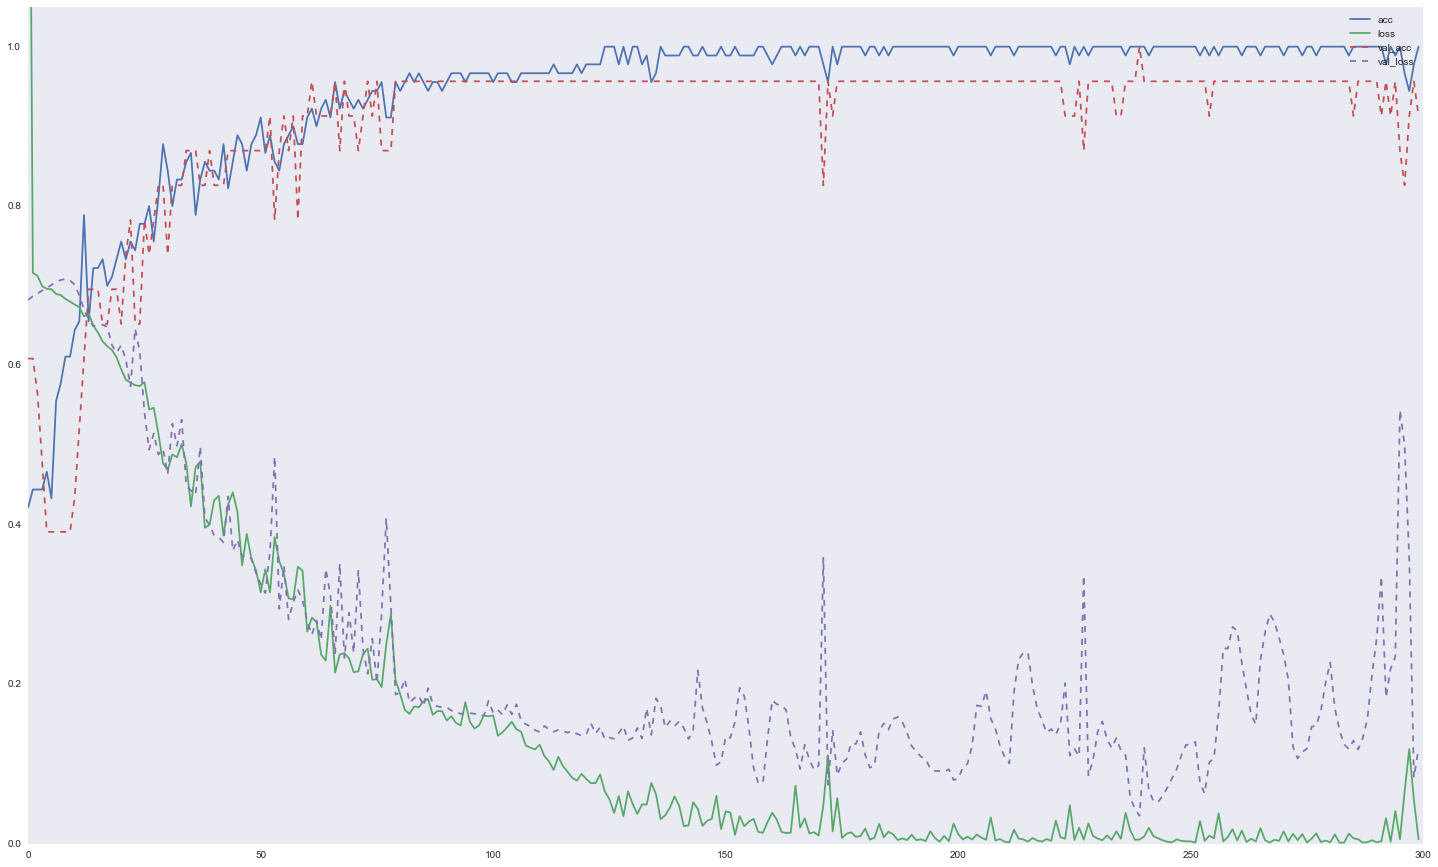

In [22]:
plt.figure(figsize=(25,15))
plt.plot(hist2.history['acc'],label='acc')
plt.plot(hist2.history['loss'],label='loss')
plt.plot(hist2.history['val_acc'],'--',label='val_acc')
plt.plot(hist2.history['val_loss'],'--',label='val_loss')
plt.legend()
plt.ylim(0,max(hist2.history['acc'])+0.05)
plt.grid('off')

In [23]:
model2.evaluate(x_te2,y_te2,batch_size=50,show_accuracy=True,verbose=1)

29/29 [==============================] - 0s


[0.59765291213989258, 0.82758620689655171]

In [24]:
model2.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 1, 50, 50)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Convolution2D (convolution2d) (None, 20, 50, 50)            2020                
Activation (activation)       (None, 20, 50, 50)            0                   
MaxPooling2D (maxpooling2d)   (None, 20, 25, 25)            0                   
Dropout (dropout)             (None, 20, 25, 25)            0                   
Convolution2D (convolution2d) (None, 10, 25, 25)            20010               
Activation (activation)       (None, 10, 25, 25)            0                   
MaxPooling2D (maxpooling2d)   (None, 10, 12, 12)            0                   
Dropout (dropout)             (None, 10, 12, 12)            0         

In [25]:
def plot_wegh (model):
    '''
    Plot weights of convolution layer
    only for first layer
    
    #Args
    model : fitted model
    '''
    wegh_arr = model.get_weights()
    num = len(wegh_arr[0])
    if type(np.sqrt(num)) is int:
        col = np.sqrt(num)
        row = np.sqrt(num) 
    else:
        col = int(num/2)
        row = int(num/col)
        
    fig ,axes = plt.subplots(row,col, subplot_kw={'xticks': [], 'yticks': []})
    plt.subplots_adjust(hspace=0.02,wspace = 0.05)
    
    for i, ax in zip(xrange(num),axes.flat):
        
        ax.imshow(wegh_arr[0][i][0])
        ax.grid('off')
    plt.show()

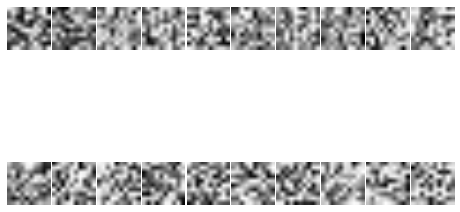

In [26]:
plot_wegh(model2)

In [27]:
m2_wegh = model2.get_weights()
for a in m2_wegh:
    print(np.shape(a))

(20L, 1L, 10L, 10L)
(20L,)
(10L, 20L, 10L, 10L)
(10L,)
(1440L, 1250L)
(1250L,)
(1250L, 2L)
(2L,)


In [28]:
s = 0
for a in m2_wegh[0]:
    s +=a[0]
    print(s)

[[ -2.60396868e-01  -1.49745524e-01  -2.09955685e-02   1.79979086e-01
   -1.99243888e-01  -2.31851071e-01   1.82278380e-01  -9.84180570e-02
   -2.84960449e-01   1.95871487e-01]
 [  1.88114326e-02  -2.12462977e-01  -6.35473873e-04   1.63013309e-01
    2.31832638e-02  -1.16938502e-02   4.17946205e-02  -1.37035295e-01
   -3.08616340e-01   2.21746027e-01]
 [  8.39083418e-02  -5.11503890e-02   1.94712505e-01   1.89417616e-01
   -3.05276841e-01  -1.35694370e-01   1.05209559e-01   9.60865393e-02
   -9.79413837e-02  -1.93383589e-01]
 [ -1.66164681e-01  -5.51766753e-02   7.11193681e-02   1.70950770e-01
   -1.57219695e-03   1.92049742e-01   8.64458755e-02  -1.17961250e-01
    7.83304870e-02   1.54979751e-01]
 [  1.40210256e-01   1.43042738e-02  -1.90259844e-01  -3.93325165e-02
    1.35293469e-01   1.59654096e-01  -1.85714871e-01  -3.60152521e-03
    6.01036754e-03   2.25166023e-01]
 [  5.96227311e-02   2.14994818e-01   1.29948378e-01  -1.41226932e-01
   -2.97811419e-01  -1.79122940e-01  -1.56235

In [29]:
y_pred2 = model2.predict_classes(np.array(x_te2))
y_pred2

29/29 [==============================] - 0s


array([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [30]:
y_ten2 = cat2lab(y_te2)
y_ten2

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1])

In [31]:
print(classification_report(y_ten2,y_pred2))

             precision    recall  f1-score   support

          0       0.88      0.64      0.74        11
          1       0.81      0.94      0.87        18

avg / total       0.83      0.83      0.82        29



### (Temp)Cross val with CNN currently not working :  cant initialize weight on interation

In [32]:
cv= StratifiedKFold(cat2lab(labels),n_folds=10,shuffle=True)

In [33]:
model5 = Sequential()
model5.add(Convolution2D(10,10, 10, border_mode='same', input_shape=(1, 50, 50)))
model5.add(Activation('relu'))
# model5.add(Convolution2D(20, 10, 10,init='uniform'))
# model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.5))



model5.add(Convolution2D(15, 10, 10,init='uniform' ,border_mode='same'))
model5.add(Activation('relu'))
# model2.add(Convolution2D(100, 5, 5,init='uniform'))
# model2.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Flatten())
model5.add(Dense(1250,init='uniform'))
model5.add(Activation('relu'))
model5.add(Dense(2,activation='softmax'))
model5.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01,decay=1e-6,
                                                              momentum=0.3,
                                                              nesterov=True))

In [34]:
# score = []
# weight = []

# for layer in model5.layers:
#     weight.append(layer.get_weights())

# for i ,(cv_tr,cv_te) in enumerate(cv):
#     for j,(layer,weight) in enumerate(zip(model5.layers,weight)):
#         layer.set_weights(None)
        

%time hist5 = model5.fit(x_tr2, y_tr2, nb_epoch=300 ,validation_split=0.2, batch_size = 50 ,show_accuracy=True ,shuffle=True)
evals = model5.evaluate(x_te2,y_te2, batch_size= 50 ,show_accuracy=True)
print(i, 'test loss : ', evals[0]  , 'test acc : ' ,evals[1])


Train on 90 samples, validate on 23 samples
Epoch 1/300
90/90 [==============================] - 0s - loss: 0.8128 - acc: 0.5222 - val_loss: 0.6241 - val_acc: 0.6087
Epoch 2/300
90/90 [==============================] - 0s - loss: 0.9178 - acc: 0.4778 - val_loss: 0.7007 - val_acc: 0.6087
Epoch 3/300
90/90 [==============================] - 0s - loss: 1.0772 - acc: 0.4667 - val_loss: 0.6135 - val_acc: 0.6522
Epoch 4/300
90/90 [==============================] - 0s - loss: 0.7296 - acc: 0.5556 - val_loss: 0.6264 - val_acc: 0.7391
Epoch 5/300
90/90 [==============================] - 0s - loss: 0.6779 - acc: 0.5667 - val_loss: 0.6320 - val_acc: 0.7826
Epoch 6/300
90/90 [==============================] - 0s - loss: 0.7309 - acc: 0.5556 - val_loss: 0.6128 - val_acc: 0.6957
Epoch 7/300
90/90 [==============================] - 0s - loss: 0.7012 - acc: 0.5222 - val_loss: 0.6187 - val_acc: 0.7826
Epoch 8/300
90/90 [==============================] - 0s - loss: 0.6835 - acc: 0.5667 - val_loss: 0.608

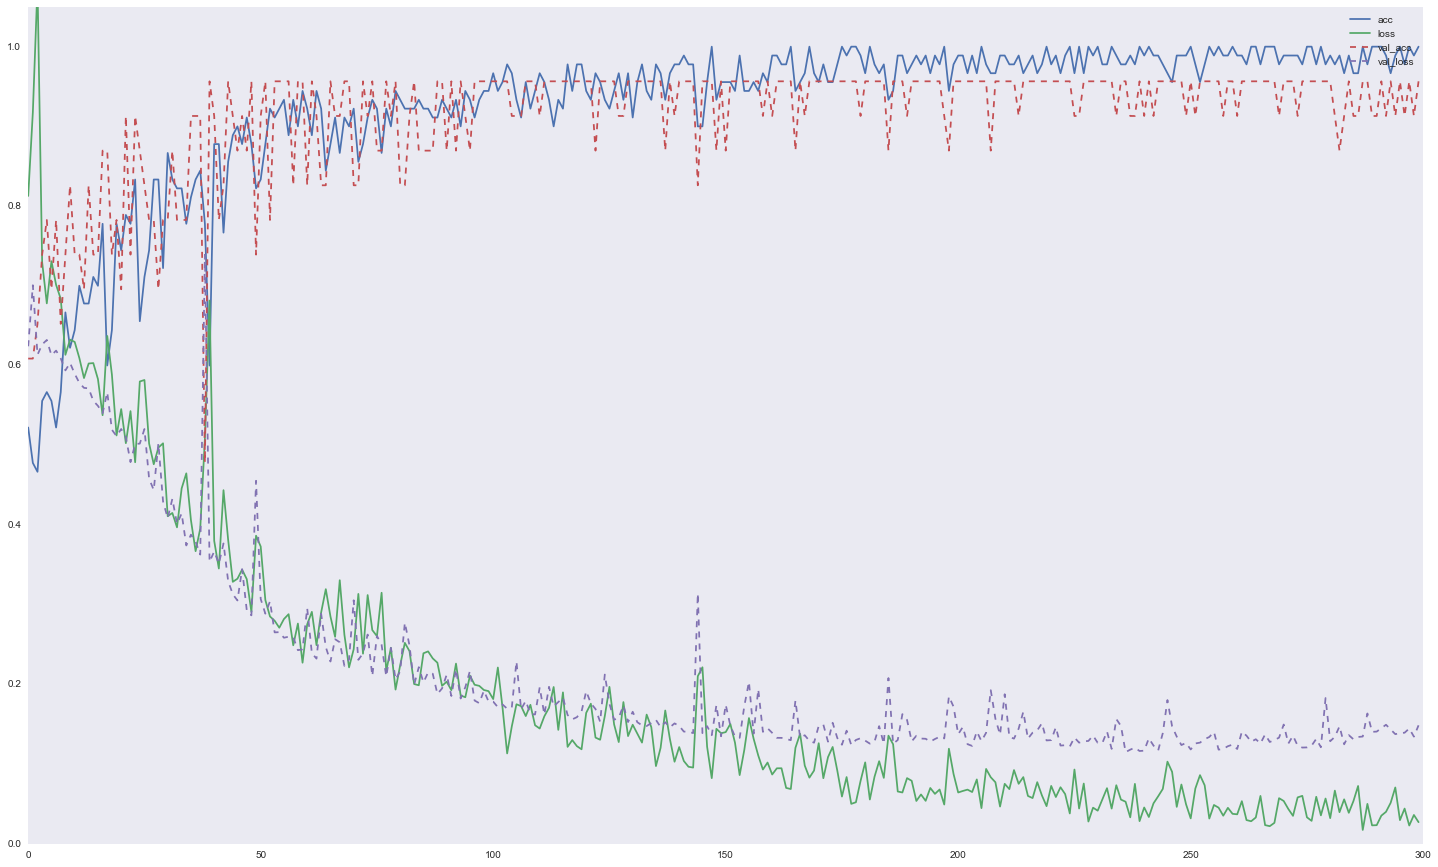

In [35]:
plt.figure(figsize=(25,15))
plt.plot(hist5.history['acc'],label='acc')
plt.plot(hist5.history['loss'],label='loss')
plt.plot(hist5.history['val_acc'],'--',label='val_acc')
plt.plot(hist5.history['val_loss'],'--',label='val_loss')
plt.legend()
plt.ylim(0,max(hist5.history['acc'])+0.05)
plt.grid('off')


## SVM

### sample수 부족??? sample 수 늘리니 결과 향상

In [36]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

In [37]:
cv = StratifiedKFold(cat2lab(labels),n_folds=10,shuffle=True)

In [38]:
params = {'C' : [1e1, 1e2, 1e3,1e4,1e5],
           'gamma' : [0.0001,0.0005,0.001,0.005,0.01]}

In [39]:
clf_grid = GridSearchCV(SVC(kernel='rbf'),params,cv=cv)

In [40]:
y_trn4 = cat2lab(y_tr1)

model4 = clf_grid.fit(imgsr,cat2lab(labels))

In [41]:
model4.best_score_ ,model4.best_params_

(0.852112676056338, {'C': 10.0, 'gamma': 0.01})

In [42]:
#demo of GridSearchCV method
svc_rslt = []
for x,y in cv: 
    clf = SVC(kernel='rbf',C=10.0,gamma = 0.005,)
    clf.fit(imgsr[x],cat2lab(labels)[x])
    svc_rslt.append(clf.score(imgsr[y], cat2lab(labels)[y]))
svc_rslt = np.array(svc_rslt)
svc_rslt

array([ 0.86666667,  0.73333333,  0.86666667,  0.86666667,  0.8       ,
        0.85714286,  0.85714286,  0.84615385,  0.92307692,  0.69230769])

In [43]:
print('cross valdated SVC score is ' , svc_rslt.mean())

cross valdated SVC score is  0.830915750916


### (temp)Wavelet transform

In [44]:
import pywt

In [45]:
Ca,Cd = pywt.dwt2(x_tr[25],'haar')

In [46]:
np.shape(Ca)

(25L, 25L)

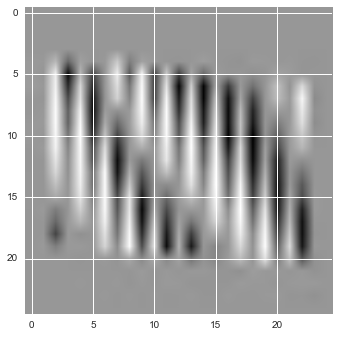

In [47]:
plt.imshow(Cd[1])

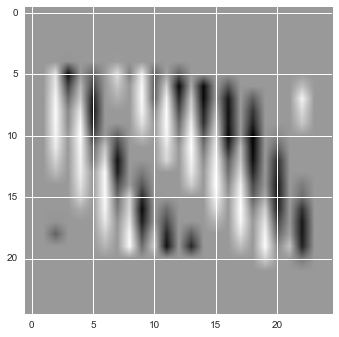

In [48]:
plt.imshow(pywt.threshold(Cd[1],0.3))

### (temp)Hough

In [49]:
from cv2 import HoughLines
from cv2 import HoughLinesP
from os import listdir
import cv2


In [50]:
asdf = listdir('d://nor/')

In [51]:
ima = cv2.imread('d://nor/'+asdf[1],1)

In [52]:
imb = cv2.Canny(ima,100,250)

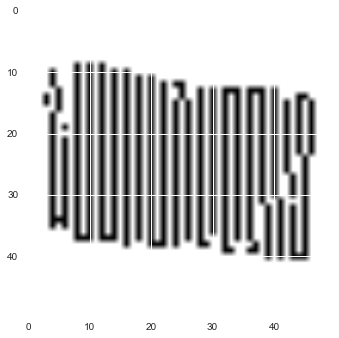

In [53]:
plt.imshow(imb)

### (temp)Harr-like feature

In [54]:
from cv2 import CascadeClassifier

### ensenble and randomforest

In [55]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [56]:
ens1 = RandomForestClassifier(n_estimators =  250 , max_depth= None,verbose=1)

ens2 = AdaBoostClassifier(SVC(kernel='rbf',gamma=0.005,C = 10.0),
                          algorithm="SAMME",
                          n_estimators=100,
                          learning_rate=0.01)


ens3  = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None),
                         algorithm="SAMME",
                         n_estimators=100,
                          learning_rate=0.01)

ens1.fit(x_tr1, cat2lab(y_tr1))
ens2.fit(x_tr1, cat2lab(y_tr1))
ens3.fit(x_tr1, cat2lab(y_tr1))


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=None)

In [57]:
ens1.score(x_te1,cat2lab(y_te1))


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


0.7931034482758621

In [58]:
ens2.score(x_te1,cat2lab(y_te1))


0.62068965517241381

In [59]:
ens3.score(x_te1,cat2lab(y_te1))

0.48275862068965519

###  Todo 